# Using deep learning to generate new music

## RNN LSTM

In [1]:
import os
import torch
from torch import nn, optim
from rnn_lstm.model import LSTM
import torch.nn
from rnn_lstm.preprocess import PreProcessor
from rnn_lstm.dataset import MusicDataset, split_train_validation
import numpy as np
from torch.utils.data import DataLoader
from rnn_lstm.training import Trainer
from rnn_lstm.melody_generation import MelodyGenerator
from IPython.display import Image
from rnn_lstm.experiments import optimizers_exp, hidden_size_exp, seq_len_exp
from rnn_lstm.settings import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}...")

Using cpu...


## Preprocessing Stage

First of all we have to process the midi files into int vectors.
For the demonstration we will use a 12 midi files.

You may try with larger number of files.

In [12]:
# pre processing the dataset
pre = PreProcessor(DEFAULT_DATASET, DEFAULT_PROCESSED_DIR)
songs = pre.process()
print(f"{songs=}")

loading files: 100%|██████████| 12/12 [00:00<00:00, 84.14it/s, file=deut5157.krn]


Loaded 12 songs.
Encoding the dataset into time series representation...
Generating single file dataset & unique mapping...
rnn_lstm\processed_dataset\mapping.json - JSON mapping file created!
songs=array([16, 13,  9, ...,  3,  3,  3])


## Dataset Loader

We use the MusicDataSet as a costum dataset which turns the sequences into one hot vectors any time a batch is drawn from it.

We take the whole data and split it into train and validation data sets in order to train the model on different data than our validation data.

In [13]:
# splitting the data to train and validation sets
train_ids, validation_ids = split_train_validation(np.arange(len(songs) - pre.seq_len))

training_set = MusicDataset(train_ids, songs, pre.mapping_file)
train_loader = DataLoader(training_set, batch_size=DEFAULT_BATCH_SIZE, shuffle=True)

validation_set = MusicDataset(validation_ids, songs, pre.mapping_file)
validation_loader = DataLoader(validation_set, batch_size=DEFAULT_BATCH_SIZE, shuffle=True)



## Defining Model

In [14]:
model = LSTM(training_set.vocabulary_size, DEFAULT_HIDDEN_SIZE, training_set.vocabulary_size, pre.mapping_file,
             device=device)

criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

## Experiments

We have experimented kfold with cross validation of different hidden sizes and optimisers and have decided to use hidden size of 256 and adam as our optimiser.

As you can see hidden sizes of 256, 512, 1024 have done well in terms of accuracy **BUT** the higher the hidden size the more time the training consumes, therefore we chose 256 as our jack of all trades.

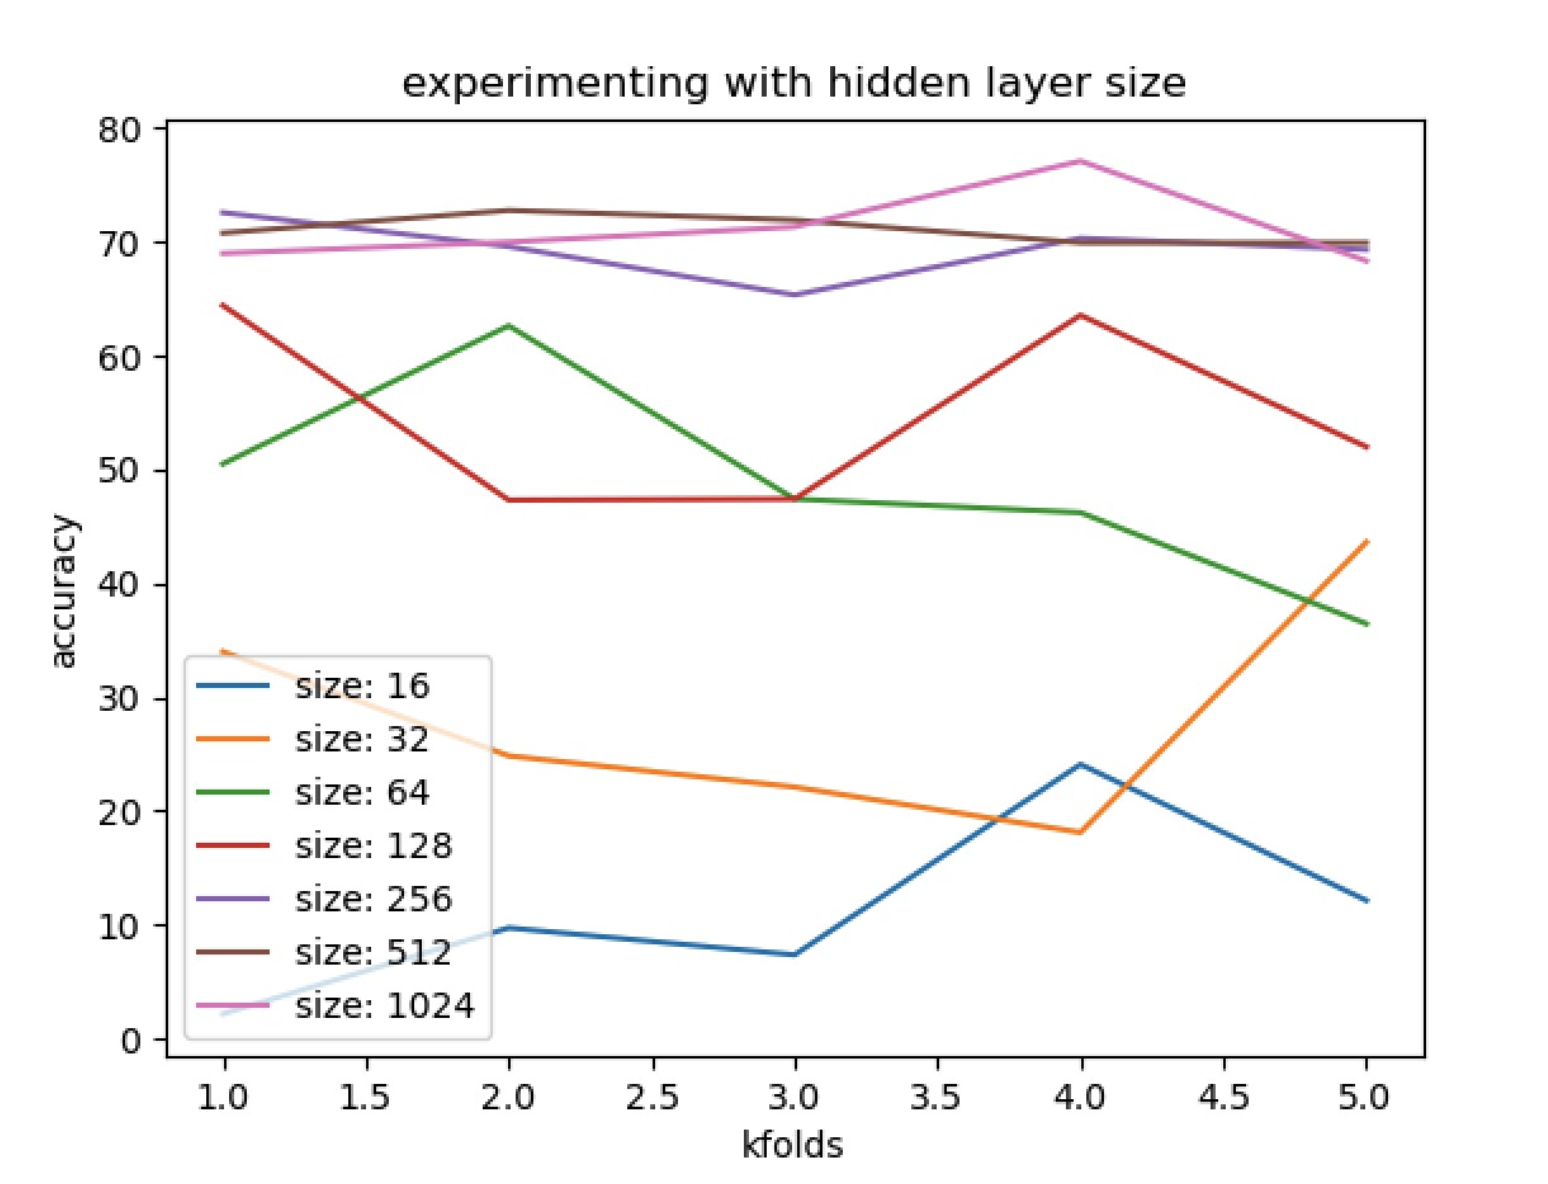

In [15]:
saved_graphs = os.path.join('rnn_lstm', 'saved_results')
Image(filename=os.path.join(saved_graphs, 'hidden_layer_exp.png'), width=600, height=600)

As for the optimiser you can see that SGD is clearly not a good option but we could choose freely from RMS and ADAM.

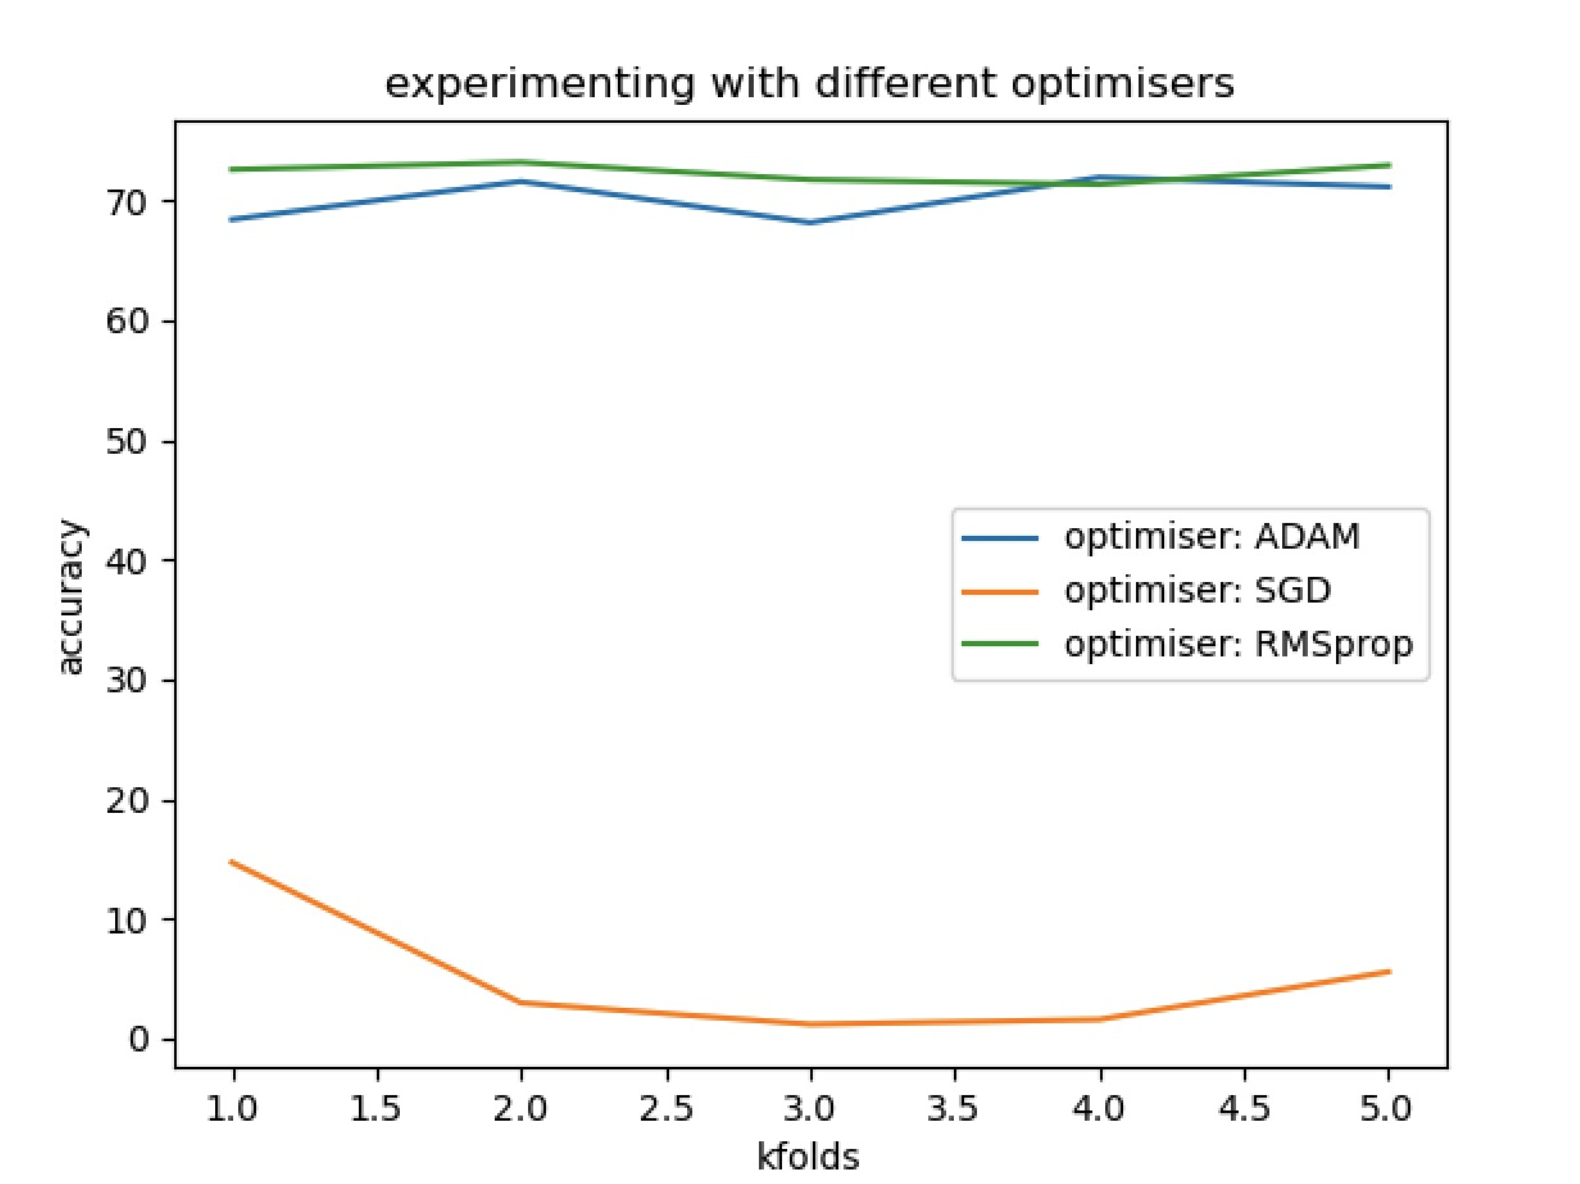

In [16]:
Image(filename=os.path.join(saved_graphs, 'optimisers_exp.png'), width=600, height=600)

Another experiment was to test the model with different trainig sequence lengths.
The results show the larger size is better **but** also takes more time to train.
Therefor we have decided to choose size of 64 because of it's good accuracy but consideratly less time to train than 128.

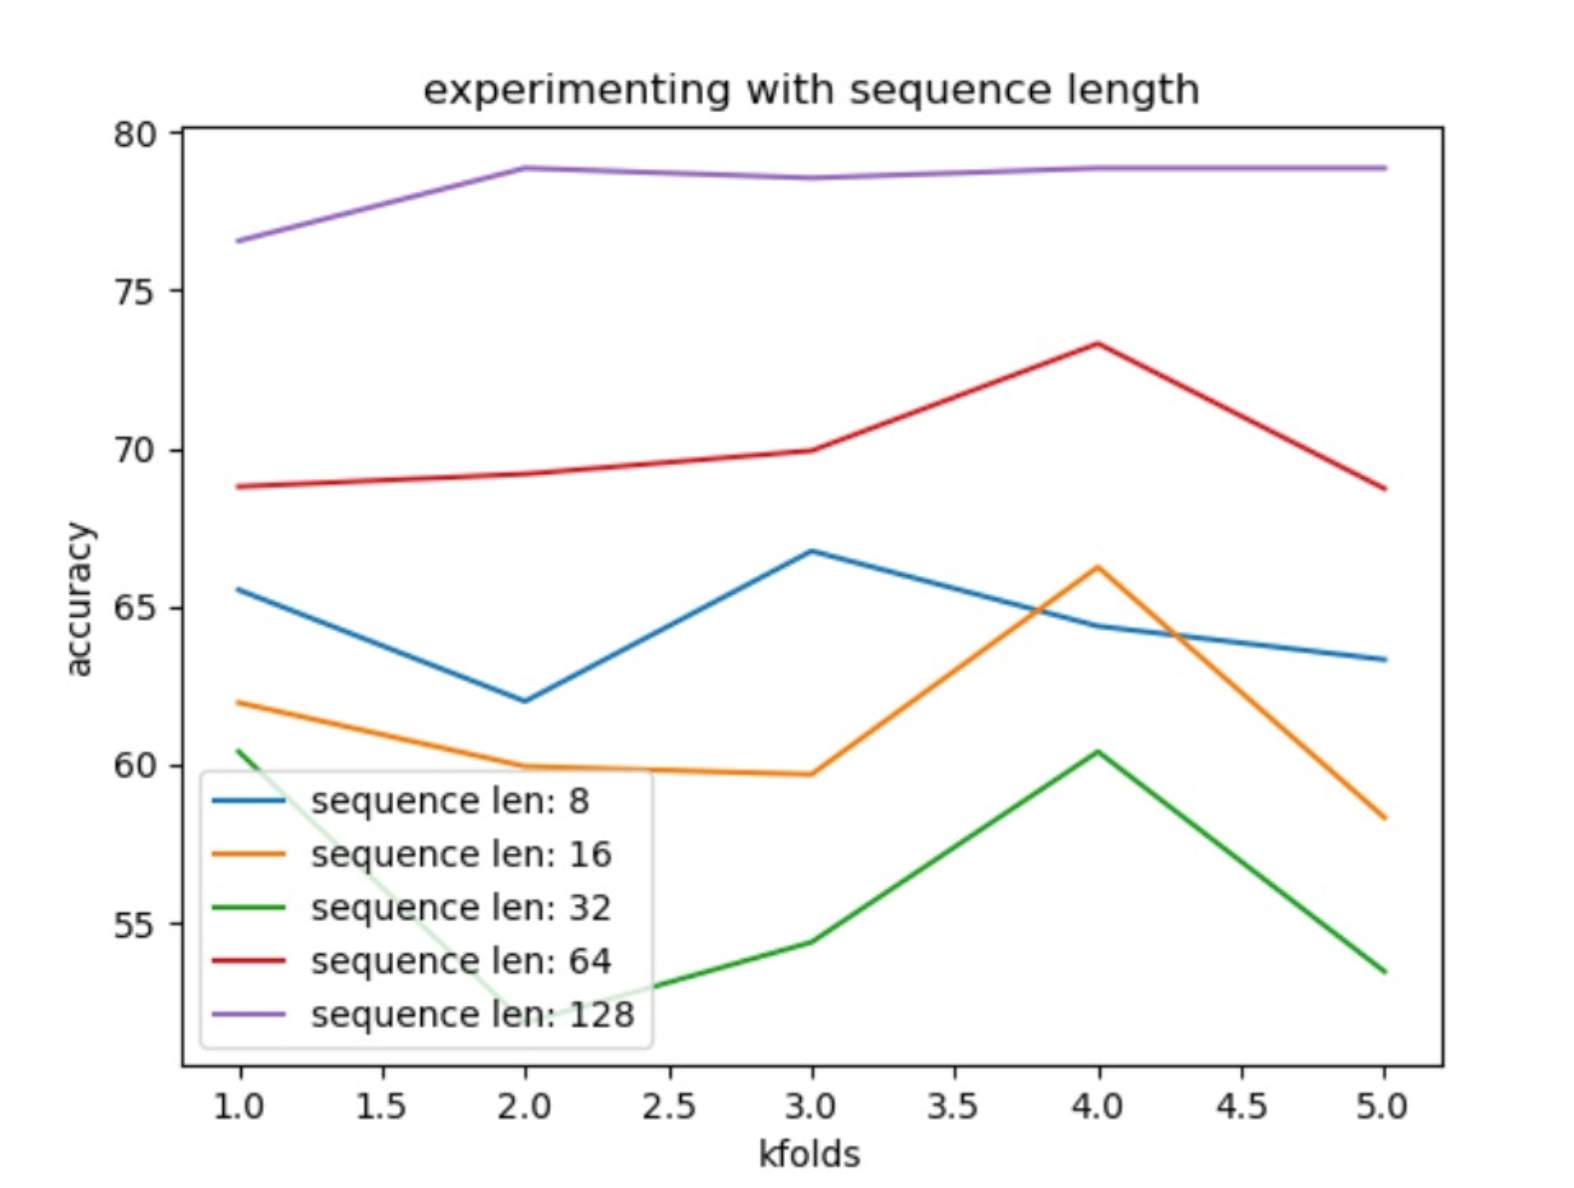

In [17]:
Image(filename=os.path.join(saved_graphs, 'seq_len_exp.png'), width=600, height=600)

You can run the experiments and change its params on your own if you'd like by uncommenting those lines of code

In [18]:
# uncomment to run experiments
# check the experiments.py file for additional args

# hidden_size_exp()

# optimizers_exp()

# seq_len_exp()

## Training Stage

In [ ]:
trainer = Trainer(model, optimiser, criterion, device=device)
trainer.fit(train_loader, validation_loader, epoches=50)

Epoch [37/50] Step [6/36]:  72%|███████▏  | 36/50 [08:07<03:07, 13.38s/it, acc=80.6, loss=0.00411] 

## Generating Melody

You may run this cell again to generate another melody!

In [ ]:
gen = MelodyGenerator(DEFAULT_TRAINED_MODELS_DIR)
song = gen.generate_melody(500, DEFAULT_SEQ_LEN, 0.85)
midi = gen.save_melody(song)

midi.show()
midi.show('midi')

## Generating melody using a pre trained model

In [ ]:
trained_erk = os.path.join(DEFAULT_TRAINED_MODELS_DIR, 'trained_erk')
gen = MelodyGenerator(trained_erk)
song = gen.generate_melody(500, DEFAULT_SEQ_LEN, 0.85)
midi = gen.save_melody(song)

midi.show()
midi.show('midi')

# Gan

In [10]:
import torch
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Preprocessing Stage

### Prepare midi dataset

In [ ]:
from gan.preprocess import prepare_dataset
songs_dir_path = os.path.join('gan','toy_set_songs')
out_merged_dir_path = os.path.join('gan', 'toy_set_merged')
data = prepare_dataset(songs_dir_path, out_merged_dir_path)

In [ ]:
print(f'{data[0]=}')

### Preprocess midi dataset

In [ ]:
from gan.preprocess import preprocess_dataset
npy_out_name = os.path.join('toy_dataset.npy')
out_merged_dir_path = os.path.join('gan', 'toy_set_merged')
out_npy_file_path = os.path.join('gan', 'toy_dataset.npy')
dataset = preprocess_dataset(out_merged_dir_path, out_npy_file_path)

## Dataset Loader

In [ ]:
from gan.dataset import Dataset
from torch.utils.data import DataLoader
dataset = Dataset(file=out_npy_file_path, max_num_files=70)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

## Define Models

### Generator

In [ ]:
from gan.gan import MidiGenerator
from gan.settings import N_TRACKS

generator = MidiGenerator()
cords = torch.rand(10, 32)
style = torch.rand(10, 32)
melody = torch.rand(10, N_TRACKS, 32)
groove = torch.rand(10, N_TRACKS, 32)

generator(cords, style, melody, groove).shape

In [ ]:
generator = MidiGenerator(z_dim=32, hid_channels=1024, hid_features=1024, out_channels=1).to(device)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.9))

### Critic

In [ ]:
from gan.gan import MidiCritic
from gan.settings import N_TRACKS, N_BARS, N_STEPS_PER_BAR
critic = MidiCritic()
a = torch.rand(10, N_TRACKS, N_BARS, N_STEPS_PER_BAR, 84)
critic(a).shape

In [ ]:
critic = MidiCritic(hid_channels=128,
                    hid_features=1024,
                    out_features=1).to(device)
c_optimizer = torch.optim.Adam(critic.parameters(), lr=0.001, betas=(0.5, 0.9))

In [ ]:
from gan.utils import initialize_weights

generator = generator.apply(initialize_weights)
critic = critic.apply(initialize_weights)

## Training Stage

In [ ]:
from gan.train import Trainer
out_path = os.path.join('gan', 'my_trained_models', 'toyModel')
trainer = Trainer(generator, critic, g_optimizer, c_optimizer, out_path, device)
num_epochs = 10
trainer.train(dataloader, epochs=num_epochs, device=device)
losses = trainer.data.copy()

## Save models and loss data

In [ ]:
import pandas as pd
import os
generator = generator.eval().cpu()
out_path = os.path.join('gan', 'my_trained_models', 'toyModel')
if not os.path.exists(out_path):
    os.makedirs(out_path)
torch.save(generator.state_dict(), os.path.join(out_path, f'generator_toy_model.pt'))
torch.save(critic.state_dict(), os.path.join(out_path, f'critic__toy_model.pt'))
losses = trainer.data.copy()
df = pd.DataFrame.from_dict(losses)
df.to_csv(os.path.join(out_path, 'results.csv'), index=False)

## Plot Losses

**Notice**: the plot data shown below relates the toy set model demo trained above, and does not reflect a well trained
model based on large data set, trained on much more epochs.

In [ ]:
import pandas as pd
from gan.utils import plot_losses
df = pd.read_csv(os.path.join(out_path, 'results.csv'))
losses = pd.DataFrame.from_dict(df)
plot_losses(losses)

## Generating Melody

In [11]:
from gan.utils import parseToMidi
from gan.settings import N_TRACKS, Z_DIM

num_samples = 1

model_path = os.path.join('gan', 'my_trained_models', 'toyModel')
gen_path =  os.path.join(model_path, f'generator_toy_model.pt')

generator = MidiGenerator()
generator.load_state_dict(torch.load(gen_path))
generator.eval()

chords = torch.randn(num_samples, Z_DIM)
style = torch.randn(num_samples, Z_DIM)
melody = torch.randn(num_samples, N_TRACKS, Z_DIM)
groove = torch.randn(num_samples, N_TRACKS, Z_DIM)

sample = generator(chords, style, melody, groove).detach()

parseToMidi(sample, midi_out_path=model_path, name="My_Track", jupyter_display_midi=True)

<music21.stream.Score 0x1642054ec10>

## Generating melody using a pre trained model

In [5]:
from gan.utils import parseToMidi
from gan.settings import N_TRACKS, Z_DIM

num_samples = 1

model_path = os.path.join('gan', 'pre_trained_models', 'modelA')
gen_path =  os.path.join(model_path, f'generator.pt')

generator = MidiGenerator()
generator.load_state_dict(torch.load(gen_path))
generator.eval()

chords = torch.randn(num_samples, Z_DIM)
style = torch.randn(num_samples, Z_DIM)
melody = torch.randn(num_samples, N_TRACKS, Z_DIM)
groove = torch.randn(num_samples, N_TRACKS, Z_DIM)

sample = generator(chords, style, melody, groove).detach()

parseToMidi(sample, midi_out_path=model_path, name="My_Track", jupyter_display_midi=True)



<music21.stream.Score 0x16419264af0>